In [2]:

import sys
import os
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
from skimage.io import imread
from st_utils import load_shape_file, vectorize, df_2_gdf
from seg_eval import calculate_tp_fn_fp_from_gdf, calculate_seg_eval_metrics
from seg_eval import translate_to_bbox, gdf_flip, calculate_area_bounds
from seg_eval import dapi_mem_mask_annotation, load_cell_boundary_parquet
from seg_eval import plot_cell_filtration, plot_cell_transcripts
from constants import PIXEL_TO_UM, sample_color, SAMPLES
from shapely.geometry import box

wd = os.getcwd()
print (f'working directory: {wd}')

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


working directory: /Users/whuan/dev/ist_benchmarking


# Load all cell segmentations

In [3]:
all_seg_filename = f'{wd}/data/all_xenium_merscope_cosmx_segmentation_2024.parquet.gzip'

if os.path.isfile(all_seg_filename):
    print (f'{all_seg_filename} is downloaded.')
    gdf_all = gpd.read_parquet(all_seg_filename)
else:
    for sample in ['2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2'][:1]:
        folder = f'{wd}/data/{sample}/segmentation_by_fov_parquet'
        if not os.path.exists(folder):
            os.makedirs(folder)

        if sample == '2024_cosmx_multitissue_htma':
            total_fov = 151
            data_dir = f'{wd}/data/cosmx/huan_tma_5724/20240430_BWH_TMA_1/20240430_203348_S1/CellStatsDir'
        else:
            total_fov = 177
            data_dir = f'{wd}/data/cosmx/huan_tma_5724/20240430_BWH_TMA2/20240430_203348_S2/CellStatsDir'

        for fov in range(1,total_fov):
            fov = str(fov).zfill(3)
            filename = f'{data_dir}/FOV{fov}/CellLabels_F{fov}.tif'
            try:
                print (filename)
                img = imread(filename)
                gdf = vectorize(img)
                gdf.to_parquet(f'{folder}/FOV_{fov}.parquet.gzip', compression='gzip')
            except:
                continue

        gdf_all = gpd.GeoDataFrame()

        for sample in SAMPLES:
            if '2024' in sample:
                print (sample)
                gdf = load_cell_boundary_parquet(sample, data_dir=f'{wd}/data')
                gdf['Sample'] = sample
                gdf_all = pd.concat([gdf_all, gdf])

        gdf_all.to_parquet(f'{wd}/data/all_xenium_merscope_cosmx_segmentation_2024.parquet.gzip', compression='gzip', index=False)



/Users/whuan/dev/ist_benchmarking/data/all_xenium_merscope_cosmx_segmentation_2024.parquet.gzip is downloaded.


In [4]:

cts = []

for core in [99, 147, 165]: # FOV: 71, 30, 8
    for sample in ['2024_xenium_breast_htma','2024_merscope_breast_htma', '2024_cosmx_multitissue_htma']:
        platform = sample.split('_')[-3]
        shapefile = f'{wd}/data/ground_truth/{core}_{platform}_annotation.shp'
        gdf_gt = load_shape_file(shapefile)
        print (sample, core, len(gdf_gt))
        cts.append(len(gdf_gt))

print (f"Total annotated cells: {sum(cts)}")

2024_xenium_breast_htma 99 1490
2024_merscope_breast_htma 99 1470
2024_cosmx_multitissue_htma 99 1093
2024_xenium_breast_htma 147 2696
2024_merscope_breast_htma 147 2631
2024_cosmx_multitissue_htma 147 1562
2024_xenium_breast_htma 165 8066
2024_merscope_breast_htma 165 6965
2024_cosmx_multitissue_htma 165 5411
Total annotated cells: 31384


# Calculate segmentation accuracy matrics and plot overlaid figure

2024_xenium_breast_htma 147


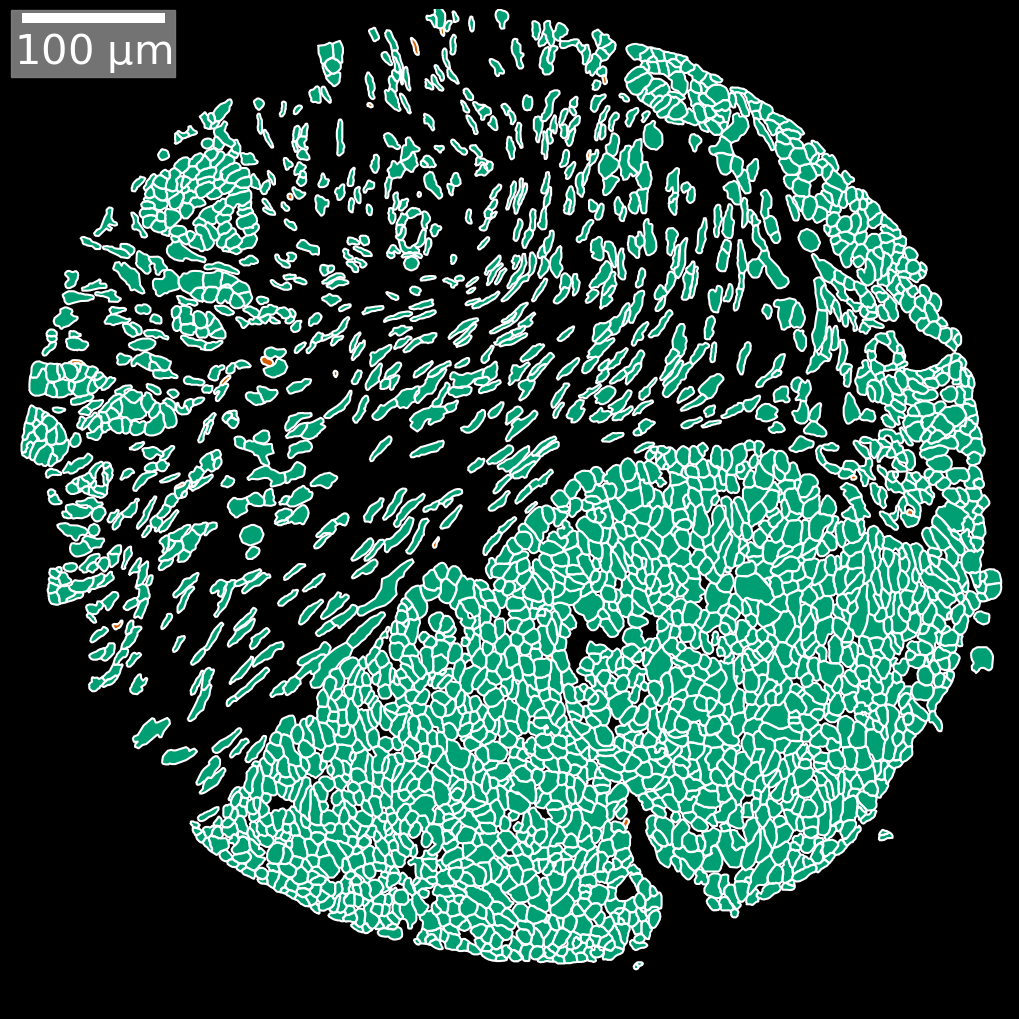

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2024_merscope_breast_htma 147


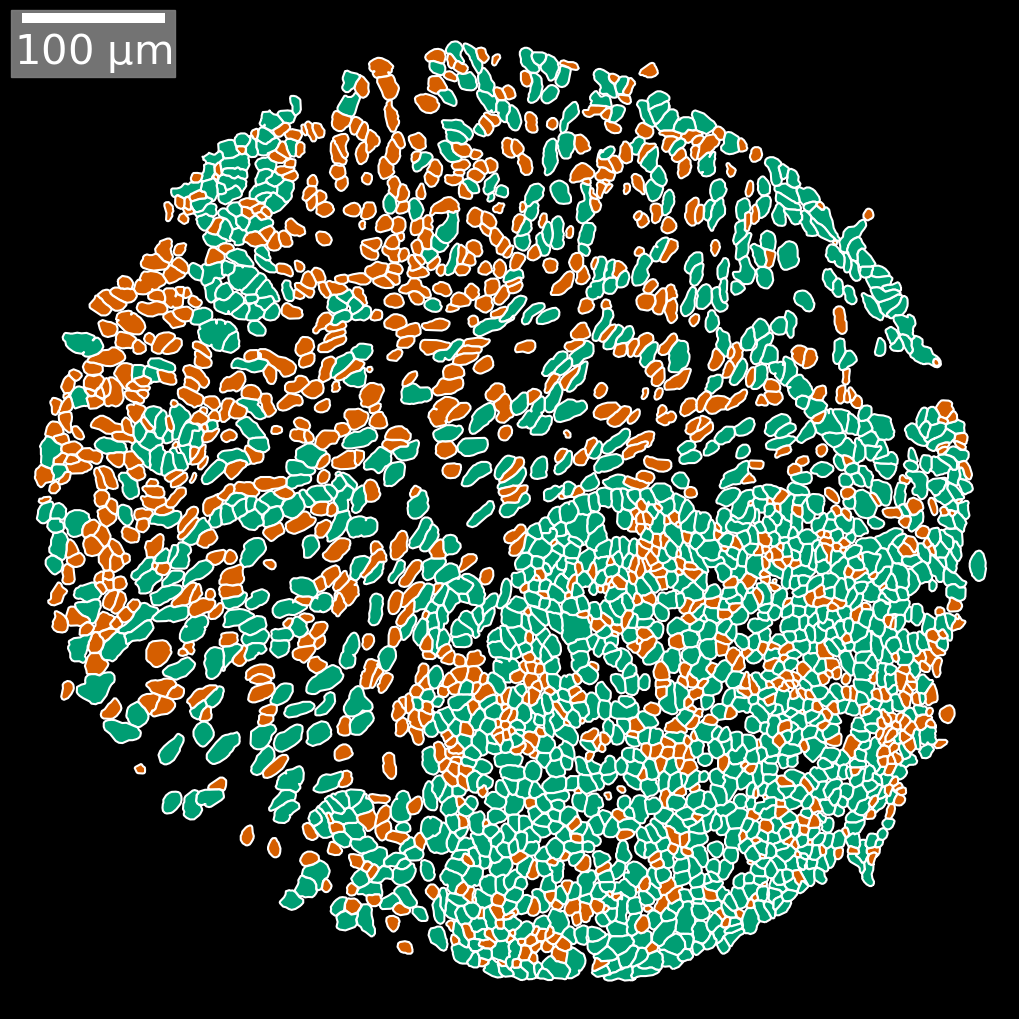

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2024_cosmx_multitissue_htma 147


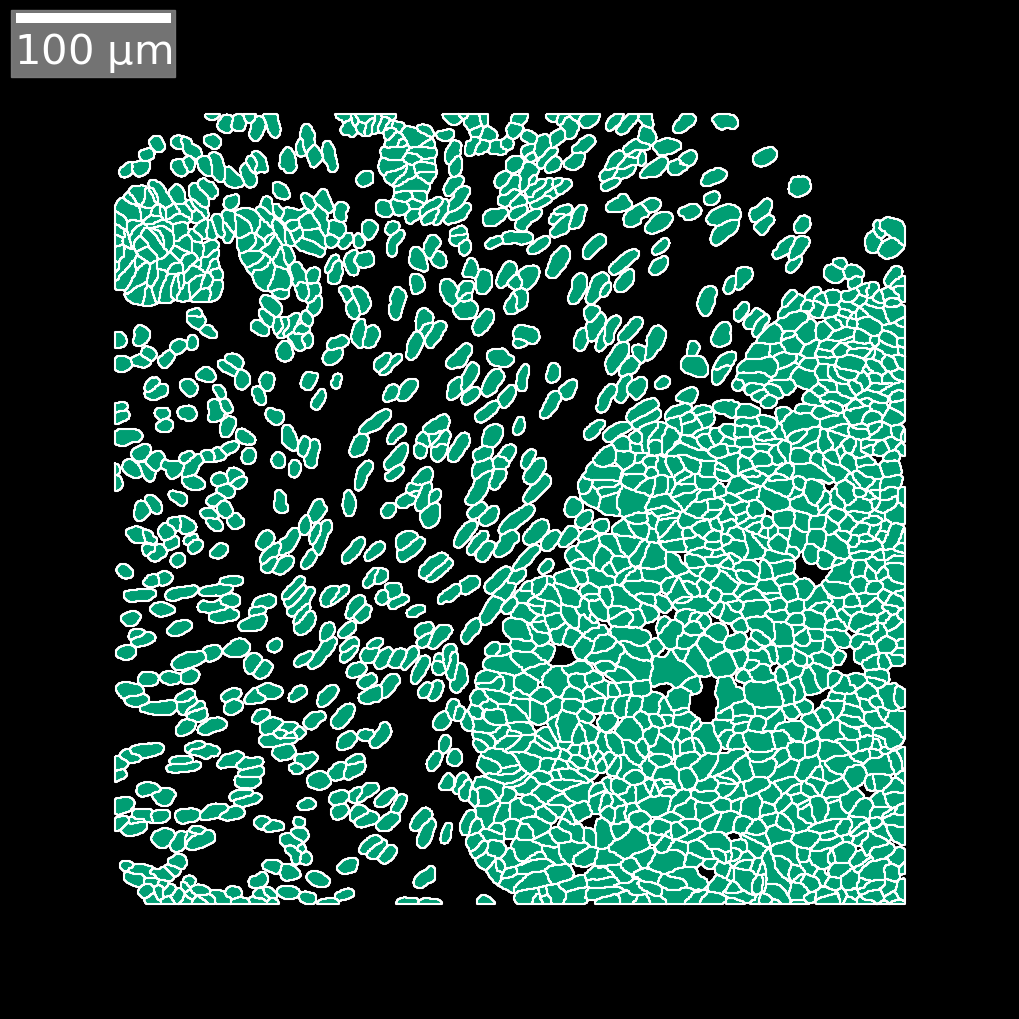

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
data_dir = f'{wd}/data/ground_truth'
plot_dapi = True
plot_filtration = True
plot_transcripts = True
scalebar_fixed_value = 100
percent = 10
figwidth = 10
scale_bar_0 = False
cosmx_bound_sclaing_factor = 1.9

metrics_list = []

for core in [99, 147, 165][1:2]: # FOV: 71, 30, 8
    for sample in ['2024_xenium_breast_htma','2024_merscope_breast_htma', '2024_cosmx_multitissue_htma']: 
        platform = sample.split('_')[-3]
        print (sample, core)
        ### Get DAPI and membrane (numpy array) and transcripts (geoDataFrame)
        if platform == 'xenium':
            filename_dapi = f'{data_dir}/{core}_{platform}.tif'
            img_dapi = imread(filename_dapi)[...,0]
            img_mem = imread(filename_dapi)[...,1]
            if plot_transcripts:
                gdf_t = gpd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip')
                gdf_t = gdf_t.loc[gdf_t['core'] == str(core)]

        elif platform == 'cosmx':
            filename_dapi = f'{data_dir}/{core}_{platform}.tif'
            img_dapi = imread(filename_dapi)[4,...]
            img_mem = imread(filename_dapi)[2,...]

            if plot_transcripts:
                columns_to_load = ['cell_id','core','x_FOV_px', 'y_FOV_px', 'gene']
                df_t = pd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip',
                                    engine='pyarrow', columns=columns_to_load)
                df_t_core = df_t.loc[df_t['core']==str(core)]
                gdf_t= df_2_gdf(df_t_core, 'x_FOV_px','y_FOV_px')

        elif platform == 'merscope':
            filename_dapi = f'{data_dir}/{core}_{platform}.tif'
            filename_mem = f'{wd}/data/{sample}/mem_by_core/{core}.tif'
            img_dapi = imread(filename_dapi)
            img_mem = imread(filename_mem)
            if plot_transcripts:
                gdf_t = gpd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip')
                gdf_t = gdf_t.loc[gdf_t['core'] == str(core)]
            
        ### gdf_mask: Segmentation from each platform, geodataframe
        gdf_sample = gdf_all.loc[gdf_all['Sample']==sample]
        gdf_sample['Platform'] = gdf_sample['Sample'].apply(lambda x: x.split("_")[-3].upper())
        ids = np.load(f'{wd}/data/good_cell_ids.npy')

        gdf_sample['Keep'] = gdf_sample['cell_id'].isin(ids).map({True: 1, False: 0})
        if plot_transcripts:
            gdf_t['Keep'] = gdf_t['cell_id'].isin(ids).map({True: 1, False: 0})


        # Get query bounding box
        if platform != 'cosmx':
            if platform == 'xenium':
                bound_box_px_file = f'{wd}/data/{sample}/dapi_by_core/bounding_box_values_px_{core}.npy'
                bound_box_values_px = np.load(bound_box_px_file)
                bound_box_values_um = bound_box_values_px * PIXEL_TO_UM[platform]
            elif platform == 'merscope':
                bound_box_um_file = f'{wd}/data/{sample}/dapi_by_core/bounding_box_values_um_{core}.npy'
                bound_box_values_um = np.load(bound_box_um_file)

            # Using bounding box to query segmentation gdf
            bounding_box = box(*bound_box_values_um)
            queried_gdf = gdf_sample[gdf_sample.intersects(bounding_box)]
            gdf_mask = translate_to_bbox(queried_gdf, bound_box_values_um, img_dapi.shape)
        else:
            gdf_mask = gdf_sample.loc[gdf_sample['core']==str(core)]

        # Flip if necessary
        if platform == 'merscope':
            gdf_mask = gdf_flip(gdf_flip(gdf_mask, direction='lr'), direction='ud')
            if plot_transcripts:
                gdf_t = gdf_flip(gdf_flip(gdf_t, direction='lr'), direction='ud')

        ### gdf_ground_truth: annotation data in geodataframe format
        shapefile = f'{wd}/data/ground_truth/{core}_{platform}_annotation.shp'
        gdf_gt = load_shape_file(shapefile)

        # Calculate matrics
        tp, fn, fp = calculate_tp_fn_fp_from_gdf(gdf_mask, gdf_gt)
        metrics = calculate_seg_eval_metrics(tp, fn, fp)
        metrics['core'] = core
        metrics['platform'] = platform
        metrics_list.append(metrics)


        if platform == 'cosmx':
            area_bounds = calculate_area_bounds(percent*cosmx_bound_sclaing_factor, img_dapi.shape[0])
            area_bounds_full = calculate_area_bounds(100*cosmx_bound_sclaing_factor, img_dapi.shape[0])
            img_dapi = np.flipud(img_dapi)
            img_mem = np.flipud(img_mem)
            gdf_gt = gdf_flip(gdf_gt, direction='ud')
            gdf_mask = gdf_flip(gdf_mask, direction='ud')
            if plot_transcripts:
                gdf_t = gdf_flip(gdf_t, direction='ud')
        else:
            area_bounds = calculate_area_bounds(percent, img_dapi.shape[0])
            area_bounds_full = calculate_area_bounds(100, img_dapi.shape[0])
        
        if core in [147]:

            if plot_dapi:
                # plot DAPI + membrane + boundary + annotation    
                scale_bar = ScaleBar(PIXEL_TO_UM[sample.split('_')[-3]], "um",
                                    fixed_value=scalebar_fixed_value,
                                color='white', box_color='grey', box_alpha=0.9, 
                                location='upper left', font_properties={'size':30})
                dapi_mem_mask_annotation(
                    img_dapi, img_mem, gdf_mask, gdf_gt, figwidth, 0.95, 0.99, scale_bar_0,
                    xy_range=True, area_bounds=area_bounds, lw=1.5, markersize=0.05, 
                    boundary_color='white', gt_color='red',
                    save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{core}_{platform}_{percent}%.png')
                
            if plot_filtration:
                # plot cell filtration 
                scale_bar = ScaleBar(PIXEL_TO_UM[sample.split('_')[-3]], "um",
                                    fixed_value=scalebar_fixed_value,
                                color='white', box_color='grey', box_alpha=0.9, 
                                location='upper left', font_properties={'size':30})
                plot_cell_filtration(
                        gdf_mask, figwidth, scale_bar_0,
                        xy_range=True, area_bounds=area_bounds_full,
                        markersize=1, boundary_color='white',save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_keep_drop_{core}_{platform}_full.png')

            if plot_transcripts:
                # plot all transcripts and specific gene
                per = 0.12 if 'cosmx' in sample else 1 # cosmx parquet generated from fov image, xenium and merscope from original output
                scale_bar = ScaleBar(per, "um", fixed_value=scalebar_fixed_value,
                                color='white', box_color='grey', box_alpha=0.9, 
                                location='upper left', font_properties={'size':30})
                for gene in ['EPCAM']:
                    if platform == 'cosmx':
                        plot_cell_transcripts(
                            gdf_t, gene, figwidth, scale_bar_0,
                            xy_range=True, area_bounds=area_bounds_full,
                            markersize=3, only_keep=False, save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{gene}_{core}_{platform}.png')
                    else:
                        plot_cell_transcripts(
                            gdf_t, gene, figwidth, scale_bar_0,
                            xy_range=False, area_bounds={},
                            markersize=3, only_keep=False, save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{gene}_{core}_{platform}.png')
                    
# Convert the list of dictionaries to a DataFrame
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.sort_values(by=['core','precision'])
if df_metrics['core'].nunique()==3:
    df_metrics.to_csv(f'{wd}/data/single_cell_metrics/segmentation_eval_results.csv', index=False)


# Segmentation evaluation using plotly

In [30]:
import plotly.express as px
import pandas as pd

# Assuming df_metrics is already loaded and processed as described
df_metrics = pd.read_csv(f'{wd}/data/single_cell_metrics/segmentation_eval_results.csv')
core_to_desc = {99: 'Sparse cells', 147: 'Elongated cells', 165: 'Dense cells'}
df_metrics = df_metrics.rename(columns={'core':'cells type'})
df_metrics['cells type'] = df_metrics['cells type'].apply(lambda x: core_to_desc[x])
df_metrics = pd.melt(df_metrics, id_vars=['cells type', 'platform'], value_vars=['precision', 'f1_score', 'iou'],
                     var_name='metric', value_name='value')
df_metrics['metric'] = df_metrics['metric'].apply(
    lambda x: {'precision': 'Precision', 'recall': 'Recall', 'f1_score': 'F1 Score', 'iou': 'IOU'}[x])
df_metrics['platform'] = df_metrics['platform'].apply(
    lambda x: {'xenium': 'Xenium', 'merscope': 'MERSCOPE', 'cosmx': 'CosMx'}[x])

custom_palette = {}
for platform in df_metrics['platform'].unique():
    custom_palette[platform] = sample_color[platform.lower()]


display(df_metrics)

fontsize = 16
width = 600
height = 700  # Adjusted for vertical layout

# Plot using Plotly Express
fig = px.bar(df_metrics, x='metric', y='value',
             barmode='group', facet_row='cells type', color='platform',
             color_discrete_map=custom_palette,
             width=width, height=height,
             labels={'value': '', 'cells type': ''})  # Adjust labels accordingly

# Update layout and axis properties globally
fig.update_layout(
    xaxis_title='',  # Removing x-axis titles globally
    yaxis_title='Metric Value',
    font=dict(size=fontsize, color='black'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        title='',
        orientation="h",  # horizontal alignment
        yanchor="bottom",
        y=1.02,  # position legend just above the plot
        xanchor="center",
        x=0.5  # center the legend
    ),
)

# Remove y-axis titles for each subplot
for axis in fig.layout:
    if axis.startswith('yaxis') and 'title' in fig.layout[axis]:
        fig.layout[axis].title.text = ''

# Update axes to show lines, applicable to all axes
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', range=[0, 1])

# Modify facet titles
for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[-1].replace('core=', '')  # Clean up facet titles

fig.show()
pio.write_image(fig, f'{wd}/figures/Fig_4_Segmentation/evaluation.png', scale=4, width=width, height=height)
pio.write_image(fig, f'{wd}/figures/Fig_4_Segmentation/evaluation.eps', scale=4, width=width, height=height)


,cells type,platform,metric,value
0,Sparse cells,MERSCOPE,Precision,0.556528
1,Sparse cells,CosMx,Precision,0.732155
2,Sparse cells,Xenium,Precision,0.734509
3,Elongated cells,MERSCOPE,Precision,0.791987
4,Elongated cells,CosMx,Precision,0.838904
5,Elongated cells,Xenium,Precision,0.842664
6,Dense cells,MERSCOPE,Precision,0.832433
7,Dense cells,Xenium,Precision,0.901997
8,Dense cells,CosMx,Precision,0.916880
9,Sparse cells,MERSCOPE,F1 Score,0.713693


# Plotting with seaborn

Simulated Raw DataFrame (`df_raw`) with 5 observations per group:


Aggregated DataFrame (`df_metrics`):


Significant Comparisons (`df_signif`):


Annotated DataFrame (`df_metrics` with significance symbols):


,core,platform,Precision,Recall,F1 Score,Precision_annot,Recall_annot,F1 Score_annot
0,Dense cells,CosMx,0.904211,0.984790,0.965632,*,*,*
1,Dense cells,MERSCOPE,0.830386,0.901730,0.857263,,,
2,Dense cells,Xenium,0.899093,0.976164,0.937272,*,*,*
3,Elongated cells,CosMx,0.829191,0.992045,0.902164,*,*,
4,Elongated cells,MERSCOPE,0.791829,0.932634,0.867846,,,
5,Elongated cells,Xenium,0.845828,0.965135,0.903892,*,,
6,Sparse cells,CosMx,0.724696,0.973972,0.835743,*,,*
7,Sparse cells,MERSCOPE,0.574062,0.984650,0.704707,,,
8,Sparse cells,Xenium,0.729031,0.980020,0.823658,*,,*


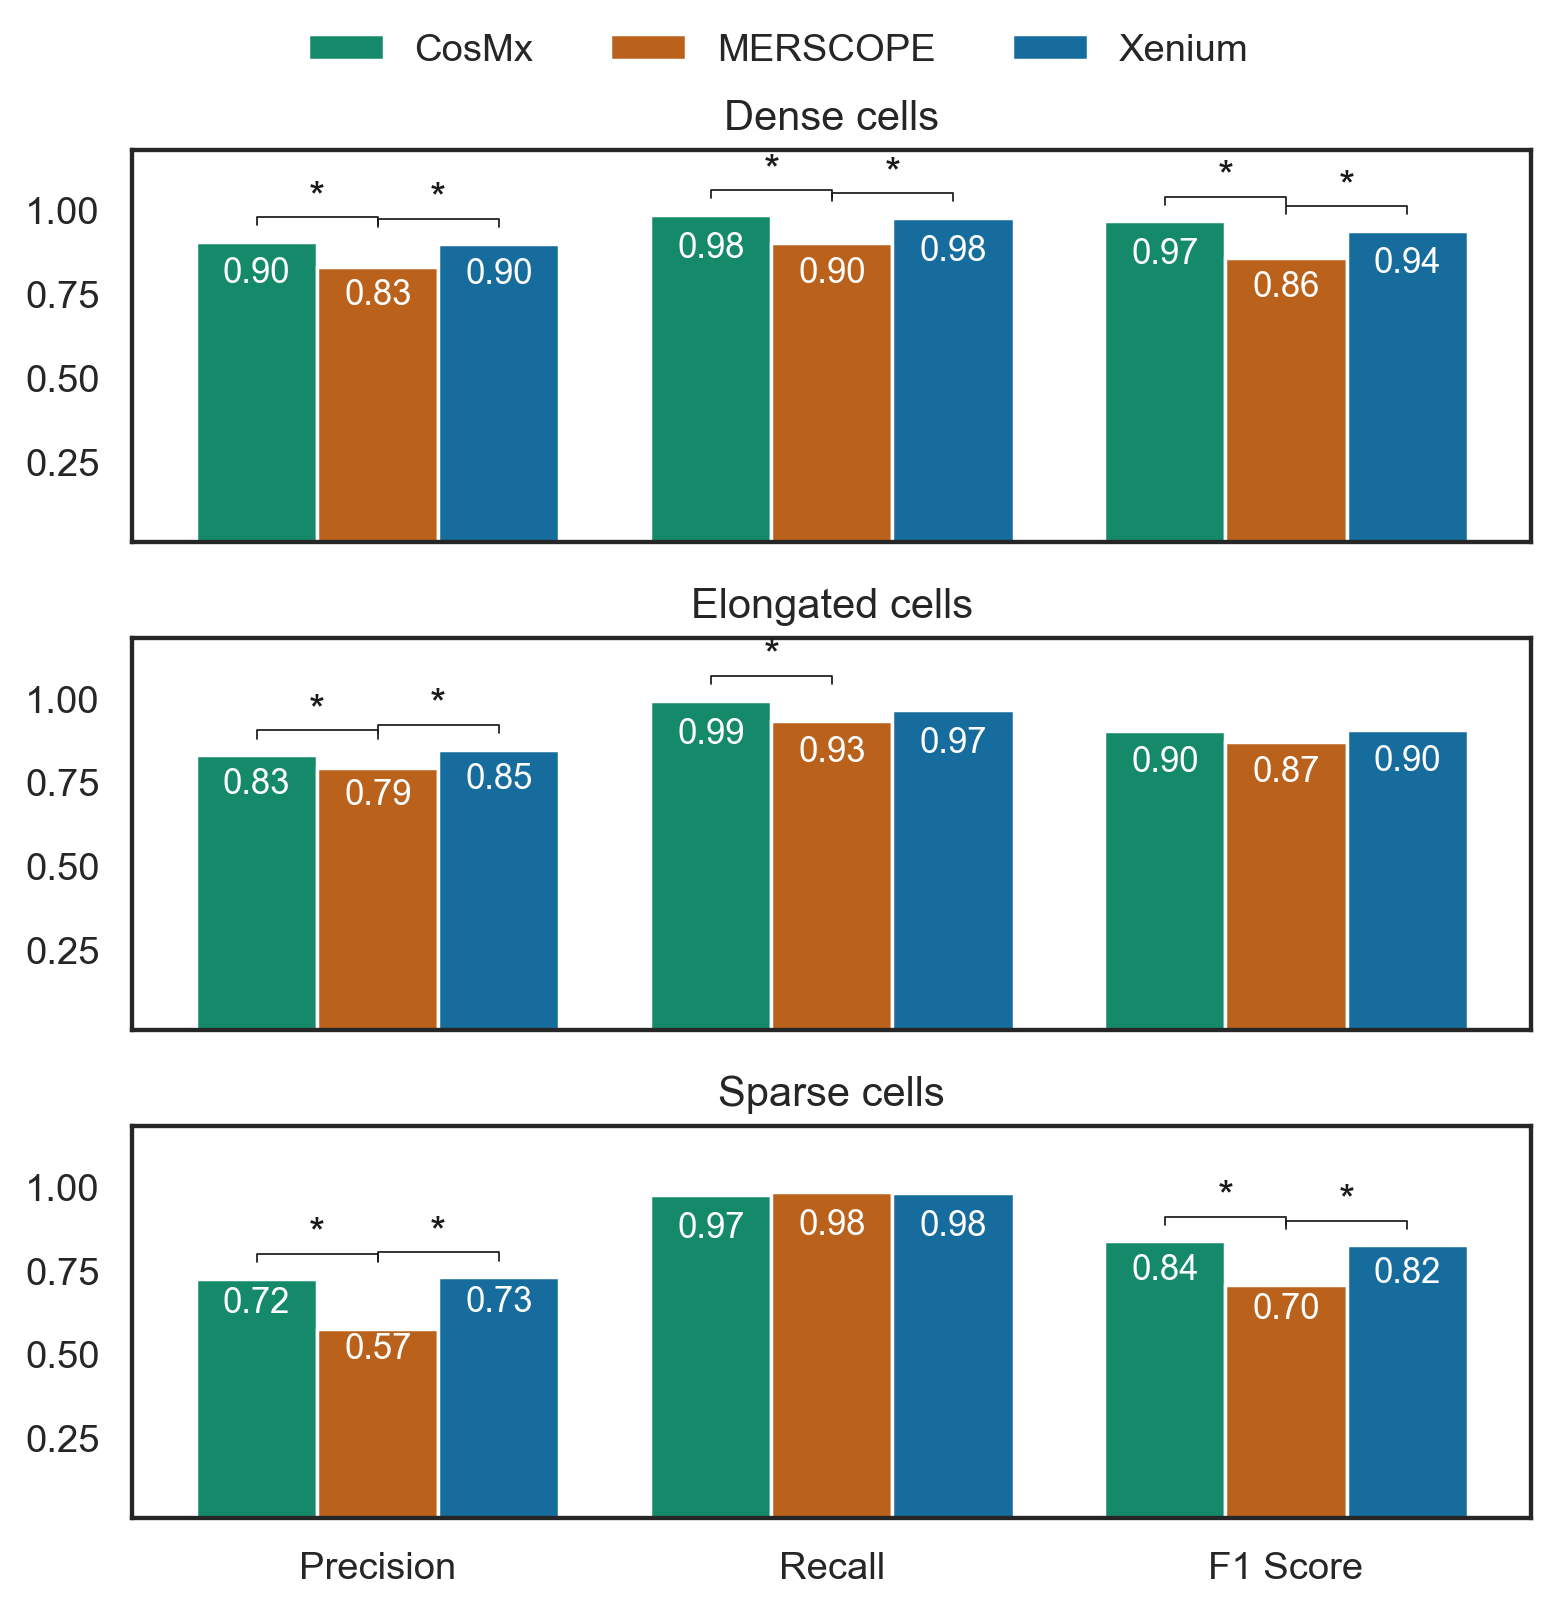

Annotated DataFrame saved as 'df_metrics_annotated.csv'


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ----------------------------------------
# Step 1: Define the Original Raw Data
# ----------------------------------------

# Assuming df_metrics is already loaded and processed as described
df_metrics = pd.read_csv(f'{wd}/data/single_cell_metrics/segmentation_eval_results.csv')
core_to_desc = {99: 'Sparse cells', 147: 'Elongated cells', 165: 'Dense cells'}
df_metrics['core'] = df_metrics['core'].apply(lambda x: core_to_desc[x])
df_metrics = df_metrics.rename(columns={
    'precision': 'Precision',
    'recall': 'Recall',
    'f1_score': 'F1 Score',
    # 'iou': 'IOU'
    })
df_metrics['platform'] = df_metrics['platform'].apply(
    lambda x: {'xenium': 'Xenium', 'merscope': 'MERSCOPE', 'cosmx': 'CosMx'}[x])

custom_palette = {}
for platform in df_metrics['platform'].unique():
    custom_palette[platform] = sample_color[platform.lower()]


df_original = df_metrics.copy()


# ----------------------------------------
# Step 2: Simulate Multiple Observations
# ----------------------------------------

# Parameters for simulation
observations_per_group = 5  # Number of simulated observations per core-platform
noise_level = {
    'Precision': 0.02,  # Standard deviation for precision
    'Recall': 0.02,  # Standard deviation for precision    
    'F1 Score': 0.02,    # Standard deviation for f1_score
    # 'IOU': 0.02          # Standard deviation for iou
}

# Seed for reproducibility
np.random.seed(42)

# Function to simulate data
def simulate_observations(row, n, noise):
    simulated = []
    for _ in range(n):
        simulated_row = {
            'Precision': np.clip(row['Precision'] + np.random.normal(0, noise['Precision']), 0, 1),
            'Recall': np.clip(row['Recall'] + np.random.normal(0, noise['Recall']), 0, 1),            
            'F1 Score': np.clip(row['F1 Score'] + np.random.normal(0, noise['F1 Score']), 0, 1),
            # 'IOU': np.clip(row['IOU'] + np.random.normal(0, noise['IOU']), 0, 1),
            'core': row['core'],
            'platform': row['platform']
        }
        simulated.append(simulated_row)
    return simulated

# Create simulated raw data
simulated_data = []
for idx, row in df_original.iterrows():
    simulated_observations = simulate_observations(row, observations_per_group, noise_level)
    simulated_data.extend(simulated_observations)

df_raw = pd.DataFrame(simulated_data)
print(f"Simulated Raw DataFrame (`df_raw`) with {observations_per_group} observations per group:")
# display(df_raw.head(15))
print("\n")

# ----------------------------------------
# Step 3: Aggregate Data to Create `df_metrics`
# ----------------------------------------

df_metrics = df_raw.groupby(['core', 'platform']).agg({
    'Precision': 'mean',
    'Recall': 'mean',
    'F1 Score': 'mean',
    # 'IOU': 'mean'
}).reset_index()

print("Aggregated DataFrame (`df_metrics`):")
# display(df_metrics)
print("\n")

# ----------------------------------------
# Step 4: Define Significance Levels and Mapping Function
# ----------------------------------------

def get_significance_symbol(p):
    """Map p-value to significance symbol."""
    if p < 0.01:
        return '*'
    else:
        return ''

# ----------------------------------------
# Step 5: Perform Statistical Tests and Collect Significance Annotations
# ----------------------------------------

# Initialize list to store significant comparisons with pair information
signif_comparisons = []

# List of cores and platforms
cores = df_metrics['core'].unique()
platforms = df_metrics['platform'].unique()

# Iterate over each core and perform tests for each metric
for core in cores:
    df_core = df_raw[df_raw['core'] == core]
    for metric in ['Precision', 'Recall','F1 Score']:
        # Perform ANOVA
        groups = df_core['platform']
        values = df_core[metric]
        
        # Check if all groups have the same value (no variance)
        if df_core.groupby('platform')[metric].nunique().min() == 1:
            # No variance, skip testing
            continue
        
        # Perform Tukey's HSD test
        try:
            tukey = pairwise_tukeyhsd(endog=df_core[metric],
                                      groups=df_core['platform'],
                                      alpha=0.05)
        except Exception as e:
            print(f"Error performing Tukey's test for core {core}, metric {metric}: {e}")
            continue
        
        # Extract results
        for res in tukey.summary().data[1:]:  # Skip header
            platform1, platform2, meandiff, p_adj, lower, upper, reject = res
            p_val = p_adj
            sig = get_significance_symbol(p_val)
            
            if sig:
                # Determine which platform has higher mean
                mean1 = df_metrics[(df_metrics['core'] == core) & (df_metrics['platform'] == platform1)][metric].values[0]
                mean2 = df_metrics[(df_metrics['core'] == core) & (df_metrics['platform'] == platform2)][metric].values[0]
                
                if mean1 > mean2:
                    higher_platform = platform1
                    lower_platform = platform2
                else:
                    higher_platform = platform2
                    lower_platform = platform1
                
                # Append to signif_comparisons
                signif_comparisons.append({
                    'core': core,
                    'metric': metric,
                    'platform1': higher_platform,
                    'platform2': lower_platform,
                    'sig': sig
                })

# Convert signif_comparisons to DataFrame
df_signif = pd.DataFrame(signif_comparisons)
print("Significant Comparisons (`df_signif`):")
# display(df_signif)
print("\n")

# ----------------------------------------
# Step 6: Annotate the Aggregated DataFrame with Significance Symbols
# ----------------------------------------

# Since we're handling annotations with bracket lines, this step is optional.
# However, for reference, we'll annotate the df_metrics with the most significant symbol per platform and metric.

for metric in ['Precision', 'Recall','F1 Score']:
    annotated_col = f"{metric}_annot"
    annotated = []
    for idx, row in df_metrics.iterrows():
        # Find if this platform is higher in any comparison for this core and metric
        signif_entries = df_signif[
            (df_signif['core'] == row['core']) &
            (df_signif['metric'] == metric) &
            (df_signif['platform1'] == row['platform'])
        ]
        if not signif_entries.empty:
            # If multiple, choose the most significant
            max_sig = signif_entries['sig'].apply(lambda x: len(x)).max()
            sig = signif_entries[signif_entries['sig'].apply(lambda x: len(x)) == max_sig]['sig'].values[0]
        else:
            sig = ''
        annotated.append(sig)
    df_metrics[f"{metric}_annot"] = annotated

print("Annotated DataFrame (`df_metrics` with significance symbols):")
display(df_metrics)
print("\n")

# ----------------------------------------
# Step 7: Generate Bar Plots with Bracket Annotations
# ----------------------------------------

def add_bracket(ax, x1, x2, y, h, text):
    """
    Draw a bracket between two x positions at a given y height.

    Parameters:
    - ax: Matplotlib Axes object.
    - x1, x2: x positions of the two bars.
    - y: y position where the bracket starts.
    - h: height of the bracket.
    - text: significance symbol to display.
    """
    # Draw the bracket
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c='k')
    # Add the text
    ax.text((x1 + x2)/2, y+h, text, ha='center', va='bottom', color='k', fontsize=12)

def annotate_bars(ax):
    """
    Add annotation inside each bar with white colored text.
    """
    for bar in ax.patches:
        ax.annotate(f'{bar.get_height():.2f}',
                    (bar.get_x() + bar.get_width() / 2, bar.get_height() * 0.9),
                    ha='center', va='center',
                    fontsize=10, color='white')

def plot_metrics_with_brackets(df_metrics, df_signif, metrics, cores, platforms, figsize=(4.5, 9)):
    """
    Plots 3 vertically arranged bar plots (one per core) with multiple metrics and significance brackets.

    Parameters:
    - df_metrics: Aggregated DataFrame with mean metrics per core-platform.
    - df_signif: DataFrame with significant comparisons.
    - metrics: List of metric column names.
    - cores: List or array of unique cores.
    - platforms: List or array of unique platforms.
    - figsize: Tuple specifying the figure size.
    """
    sns.set(style='white', rc={'figure.dpi': 250})
    num_cores = len(cores)


    custom_palette = {}
    for platform in df_metrics['platform'].unique():
        custom_palette[platform] = sample_color[platform.lower()]
    
    # Create subplots: 3 rows, 1 column
    fig, axes = plt.subplots(num_cores, 1, figsize=figsize, sharey=True, sharex=True)
    
    # If only one core, axes is not a list
    if num_cores == 1:
        axes = [axes]
    
    # Define bar width
    bar_width = 0.8 / len(metrics)  # Total width is 0.8
    
    # Iterate over each core to create individual plots
    for i, core in enumerate(cores):
        ax = axes[i]

        # Set axes background transparent
        ax.set_facecolor('none')

        # Remove grid lines
        ax.grid(False)

        df_core = df_metrics[df_metrics['core'] == core]
        
        # Order platforms for consistency
        df_core = df_core.set_index('platform').loc[platforms].reset_index()
        
        # Melt the DataFrame to long format for easier plotting
        df_melted = df_core.melt(id_vars=['core', 'platform'], value_vars=metrics, var_name='metric', value_name='value')
        
        
        # Plot seaborn barplot with hue='platform'
        sns.barplot(x='metric', y='value', hue='platform', data=df_melted, ax=ax, palette=custom_palette, ci='sd')
        
        # Set title and labels
        ax.set_title(f'{core}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Remove individual legend
        ax.legend().remove()

        annotate_bars(ax)
        
        # Determine the maximum y value to position brackets
        ymax = df_melted['value'].max()
        h = ymax * 0.05  # Height of the bracket
        
        # Filter significant comparisons for this core
        df_core_signif = df_signif[df_signif['core'] == core]
        
        for _, row in df_core_signif.iterrows():
            metric = row['metric']
            platform1 = row['platform1']
            platform2 = row['platform2']
            sig = row['sig']
            
            if sig == '':
                continue  # Skip if no significance
            
            # Find the x position of the metric
            metric_idx = metrics.index(metric)
            
            # Calculate the total bar width per metric
            n_metrics = len(metrics)
            total_width = 0.8
            bar_width = total_width / n_metrics
            
            # Find the number of platforms
            n_platforms = len(platforms)
            
            # Calculate the x positions for platform1 and platform2
            # Seaborn's barplot places bars for each hue side by side within each x category
            # The exact positioning can be approximated
            
            # Calculate bar offset based on hue order
            platform1_idx = list(platforms).index(platform1)
            platform2_idx = list(platforms).index(platform2)
            
            # Total number of platforms
            n_platforms = len(platforms)
            
            # Calculate the position of each platform's bar within the metric
            # Assuming 'muted' palette, hue_order is sorted as per 'platforms'
            # Bars are spaced evenly within each metric
            
            # Each metric is at positions 0,1,2,... on x-axis
            # The first platform is slightly to the left, the last to the right
            
            # Calculate the width adjustment
            width_adjust = 0.8
            # Calculate the positions
            # For simplicity, assume bars are centered around metric index
            # Calculate the shift based on number of platforms
            # Each platform shifts by (platform_idx - (n_platforms-1)/2) * bar_width
            
            x_base = metric_idx
            shift = (platform1_idx - (n_platforms - 1) / 2) * bar_width
            x1 = x_base + shift
            shift = (platform2_idx - (n_platforms - 1) / 2) * bar_width
            x2 = x_base + shift
            
            # Get the heights of the bars
            y1 = df_melted[
                (df_melted['metric'] == metric) & 
                (df_melted['platform'] == platform1)
            ]['value'].values[0]
            y2 = df_melted[
                (df_melted['metric'] == metric) & 
                (df_melted['platform'] == platform2)
            ]['value'].values[0]
            
            # Set the y position for the bracket
            y = max(y1, y2) + h
            
            # Add the bracket
            add_bracket(ax, x1, x2, y, h*0.5, sig)
        
        # Adjust y-axis to make room for brackets
        ax.set_ylim(0.01, 1.18)
    
    # Create a single legend at the top center with transparent background
    handles, labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper center', ncol=len(platforms), title='', framealpha=0)

    
    plt.tight_layout(rect=[0, 0.0, 0.9, 0.97])  # Adjust layout to make room for the legend

    plt.savefig(f'{wd}/figures/Fig_4_Segmentation/evaluation.png', transparent=True)
    plt.savefig(f'{wd}/figures/Fig_4_Segmentation/evaluation.eps', transparent=True)

    plt.show()

    return ax

metrics = ['Precision', 'Recall','F1 Score']
ax = plot_metrics_with_brackets(df_metrics, df_signif, metrics, cores, platforms, figsize=(7, 6.5))

# ----------------------------------------
# Step 8: Save the Annotated DataFrame as a CSV
# ----------------------------------------

output_csv = 'df_metrics_annotated.csv'
df_metrics.to_csv(output_csv, index=False)
print(f"Annotated DataFrame saved as '{output_csv}'")


# Generate legend for the whole figure

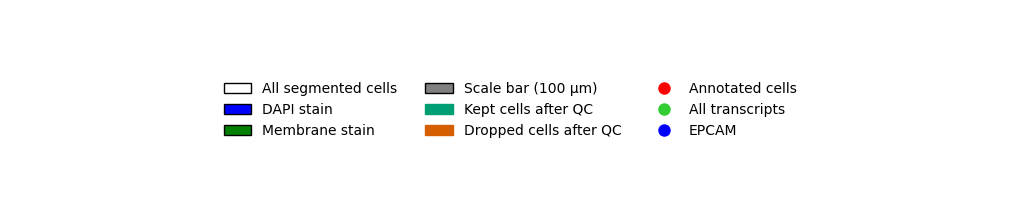

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

gene = 'EPCAM'
dot_size = 10
legend_elements = [
    Patch(facecolor='none', edgecolor='black', label='All segmented cells'),
    Patch(facecolor='Blue', edgecolor='black', label='DAPI stain'),
    Patch(facecolor='Green', edgecolor='black', label='Membrane stain'),
    Patch(facecolor='Gray', edgecolor='black', label='Scale bar (100 µm)'),
    Patch(facecolor='#009E73', edgecolor='#009E73', label='Kept cells after QC'),
    Patch(facecolor='#D55E00', edgecolor='#D55E00', label='Dropped cells after QC'),
    Line2D([0], [0], marker='o', color='w', label='Annotated cells', markerfacecolor='red', markersize=dot_size),
    Line2D([0], [0], marker='o', color='w', label='All transcripts', markerfacecolor='limegreen', markersize=dot_size),
    Line2D([0], [0], marker='o', color='w', label=f'{gene}', markerfacecolor='blue', markersize=dot_size)
]

# Create the figure
fig, ax = plt.subplots(figsize=(10, 2))
legend = ax.legend(handles=legend_elements, loc='center', ncol=3)  # Set ncol to 3 for three columns

# Hide the frame of the legend
legend.set_frame_on(False)

# Remove axes
plt.axis('off')

# Adjust subplots to remove any internal margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Save the figure
fig.savefig('figures/segmentation_legend.png', format='png', dpi=500, transparent=True, bbox_inches='tight')
fig.savefig('figures/segmentation_legend.eps', format='eps', dpi=500, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()


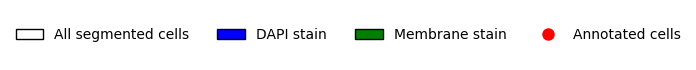

In [19]:

dot_size = 10
legend_elements = [
    Patch(facecolor='none', edgecolor='black', label='All segmented cells'),
    Patch(facecolor='Blue', edgecolor='black', label='DAPI stain'),
    Patch(facecolor='Green', edgecolor='black', label='Membrane stain'),
    Line2D([0], [0], marker='o', color='w', label='Annotated cells', markerfacecolor='red', markersize=dot_size),
]

# Create the figure
fig, ax = plt.subplots(figsize=(3,0.5))
legend = ax.legend(handles=legend_elements, loc='center', ncol=4)  # Set ncol to 3 for three columns

# Hide the frame of the legend
legend.set_frame_on(False)

# Remove axes
plt.axis('off')

# Adjust subplots to remove any internal margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Save the figure
fig.savefig('figures/segmentation_legend_row_1.png', format='png', dpi=500, transparent=True, bbox_inches='tight')
fig.savefig('figures/segmentation_legend_row_1.eps', format='eps', dpi=500, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()


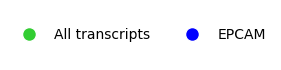

In [17]:

gene = 'EPCAM'
dot_size = 10
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='All transcripts', markerfacecolor='limegreen', markersize=dot_size),
    Line2D([0], [0], marker='o', color='w', label=f'{gene}', markerfacecolor='blue', markersize=dot_size)
]


# Create the figure
fig, ax = plt.subplots(figsize=(2,0.5))
legend = ax.legend(handles=legend_elements, loc='center', ncol=2)

# Hide the frame of the legend
legend.set_frame_on(False)

# Remove axes
plt.axis('off')

# Adjust subplots to remove any internal margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Save the figure
fig.savefig('figures/segmentation_legend_row_2.png', format='png', dpi=500, transparent=True, bbox_inches='tight')
fig.savefig('figures/segmentation_legend_row_2.eps', format='eps', dpi=500, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()


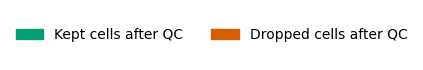

In [18]:

legend_elements = [
    Patch(facecolor='#009E73', edgecolor='#009E73', label='Kept cells after QC'),
    Patch(facecolor='#D55E00', edgecolor='#D55E00', label='Dropped cells after QC')]

# Create the figure
fig, ax = plt.subplots(figsize=(2, 0.5))
legend = ax.legend(handles=legend_elements, loc='center', ncol=2)
# Hide the frame of the legend
legend.set_frame_on(False)

# Remove axes
plt.axis('off')

# Adjust subplots to remove any internal margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Save the figure
fig.savefig('figures/segmentation_legend_row_3.png', format='png', dpi=500, transparent=True, bbox_inches='tight')
fig.savefig('figures/segmentation_legend_row_3.eps', format='eps', dpi=500, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()